# Setup system

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env FLOX_STRICT_TYPING=True

env: FLOX_STRICT_TYPING=True


In [3]:
import flox

In [4]:
""" core system definitions """


from functools import partial
from typing import Callable, TypeVar

import jax
from jax import numpy as jnp
from jax_dataclasses import pytree_dataclass
from jaxtyping import Array, Float  # type: ignore
import jax.scipy as jscipy
from flox.flow import Transformed

from flox.util import key_chain

T = TypeVar("T")

Scalar = Float[Array, ""] | float
VectorN = Float[Array, "N"]

Potential = Callable[[T], Scalar]

def double_well_potential(
    x: Scalar,
    a: Scalar = 2,
    b: Scalar = 5,
    c: Scalar = 0.5
) -> Scalar:
    """ The simple double potential """
    return jnp.sum(a * x ** 4 - b * x ** 2 + c * x ** 3)


def harmonic_potential(x: Scalar) -> Scalar:
    """ The simple harmonic potential """
    return jnp.sum(x ** 2)


@pytree_dataclass
class State:
    """ State holding the reaction coordinate
        and auxiliary noise.
    """
    pos: VectorN
    aux: VectorN


def joint_base_potential(s: State) -> Scalar:
    """ combine both potentials into one """
    return jnp.sum(harmonic_potential(s.pos) + harmonic_potential(s.aux))


def joint_target_potential(s: State) -> Scalar:
    """ combine both potentials into one """
    return jnp.sum(double_well_potential(s.pos) + harmonic_potential(s.aux))


def sample_base(key: jax.random.PRNGKeyArray) -> Transformed[State]:
    chain = key_chain(key)
    pos = jax.random.normal(next(chain), shape=(1,))
    aux = jax.random.normal(next(chain), shape=(1,))
    logprob = -jnp.sum(
        jscipy.stats.norm.logpdf(pos)
        +
        jscipy.stats.norm.logpdf(aux)
    )
    return Transformed(State(pos, aux), logprob)

In [5]:
""" init random state. """

seed = 42
chain = key_chain(seed)

# Plotting tools

In [7]:
""" plotting tools """

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def plot_potential(potential: Potential, left=-2, right=1.5, res=100):
    """ plot the potential """
    xs = jnp.linspace(left, right, res)
    us = jax.vmap(potential)(xs)
    plt.plot(xs, us)


def density(potential: Potential, left=-3, right=3, res=1000) -> tuple[Array, Array]:
    """ get the density for plotting """
    xs = jnp.linspace(left, right, res)
    us = jax.vmap(potential)(xs)
    pis = jnp.exp(-us)
    Z = jnp.trapz(pis, xs)
    ps = pis / Z
    return xs, ps


def plot_samples(
    s: State,
    potentials: tuple[Potential, Potential] | None = None,
    weights: Float[Array, "N"] | None = None,
    bins: tuple[int, int] = (50, 50),
    range: tuple[tuple[float, float], tuple[float, float]] = ((-3, 3), (-3, 3)),
    label: str | None = None
):
    """ plot samples """

    mosaic = [
        ["pos", "aux"],
        ["joint", "joint"]
    ]
    if weights is not None:
        mosaic.append(
            ["joint_weighed", "joint_weighed"]
        )
    fig, axes = plt.subplot_mosaic(mosaic, figsize=(8, 8 + (1 if weights is not None else 0)))

    for i, (ax, data, title) in enumerate(zip(("pos", "aux"), (s.pos, s.aux), ("pos", "aux"))):
        axes[ax].hist(data[:, 0], bins=bins[i], density=True, histtype="step", range=range[i],  # type: ignore
                      label="samples", color="blue")
        axes[ax].set_title(title)  # type: ignore

    if weights is not None:
        for i, (ax, data, title) in enumerate(zip(("pos", "aux"), (s.pos, s.aux), ("pos", "aux"))):
            axes[ax].hist(data[:, 0], bins=bins[i], density=True, histtype="step", range=range[i],  # type: ignore
                          label="samples (reweighed)", color="green", weights=weights)
    if potentials is not None:
        for ax, pot in zip(("pos", "aux"), potentials, strict=True):
            xs, ps = density(pot)
            axes[ax].plot(xs, ps, color="red", label="density")  # type: ignore
    
    for ax in ("pos", "aux"):
        axes[ax].legend()  # type: ignore
    
    axes["joint"].hist2d(s.pos[:, 0], s.aux[:, 0], bins=bins, range=range)  # type: ignore
    axes["joint"].set_title("joint")  # type: ignore

    if weights is not None:
        axes["joint_weighed"].hist2d(s.pos[:, 0], s.aux[:, 0], bins=bins, range=range, weights=weights)  # type: ignore
        axes["joint_weighed"].set_title("joint (reweighed)")  # type: ignore
    if label is not None:
        fig.suptitle(label)  # type: ignore

# Sample from target potential

In [8]:
""" use numpyro sampler """

import numpyro as npy  # type: ignore
from jaxtyping import PyTree  # type: ignore


def sample(
    key: jax.random.PRNGKeyArray,
    potential_fn: Potential[T],
    num_samples: int,
    init: T,
    num_chains: int,
    num_warmup: int
) -> T:
    """ samples from potential using numpyro's no-u-turn sampler (HMC). """
    mcmc = npy.infer.MCMC(npy.infer.NUTS(potential_fn=potential_fn), num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc.run(key, init_params=init)
    return mcmc.get_samples()

In [9]:
num_chains = 1

init = State(
    jax.random.normal(next(chain), (num_chains,)),
    jax.random.normal(next(chain), (num_chains,))
)

npy.set_host_device_count(num_chains)
data = sample(
    next(chain),
    joint_target_potential,
    num_samples=10_000,
    init=init,
    num_chains=num_chains,
    num_warmup=100
)

sample: 100%|██████████| 10100/10100 [00:13<00:00, 771.29it/s, 21 steps of size 1.72e-01. acc. prob=0.96]


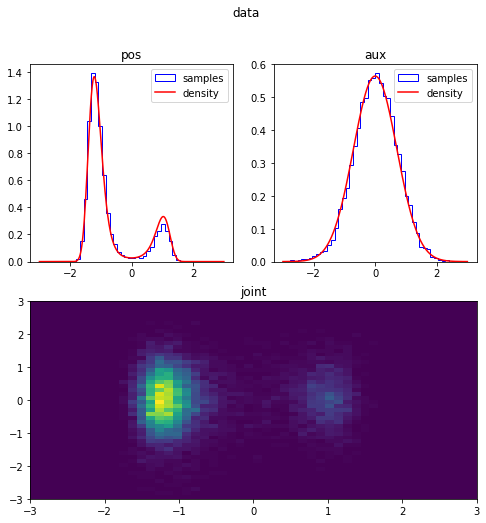

In [10]:
""" plot data """

plot_samples(data, (double_well_potential, harmonic_potential), label="data")

---

# Define flow

In [21]:
""" Define the flows. """

import distrax
import haiku as hk
import lenses

from flox.flow import (
    Pipe,
    SimpleCoupling,
    Transform,
    Transformed,
    Affine,
    DistraxWrapper
)
from flox.util import Lens
from flox.nn import haiku as fhk

NUM_FLOW_LAYERS = 3
NUM_HIDDEN = 128
NUM_BINS = 8


class MySplineTransform(hk.Module):

    def __init__(self, field: Callable[[State], VectorN], num_hidden: int, num_bins: int, dims: int, activation=jax.nn.silu):
        super().__init__(name="position_transform")
        self.field = field
        self.net = fhk.dense([num_hidden, 3 * num_bins + 1], activation)

    def __call__(self, s: State) -> DistraxWrapper:
        params = self.net(self.field(s))
        return DistraxWrapper(
            distrax.RationalQuadraticSpline(
                params, range_min=-5., range_max=5.
            )
        )

class MyAffineTransform(hk.Module):

    def __init__(self, field: Callable[[State], VectorN], num_hidden: int, dims: int, activation=jax.nn.silu):
        super().__init__(name="auxiliary_transform")
        self.field = field
        self.net = fhk.dense([num_hidden, 2 * dims], activation=activation)

    def __call__(self, s: State) -> Affine:
        shift, scale = jnp.split(self.net(self.field(s)), 2)
        return Affine(shift, scale * 1e-1)


def get_aux(s: State) -> VectorN:
    return s.aux

def update_aux(s: State, aux: VectorN) -> State:
    return lenses.bind(s).aux.set(aux)
    
def get_pos(s: State) -> VectorN:
    return s.pos

def update_pos(s: State, pos: VectorN) -> State:
    return lenses.bind(s).pos.set(pos)


"""

State -> Transformed[State] = (State, Volume)

Seq: T -> 

Wrap: T -> V[T]
Seq: [ ... V[T] ... ] -> V[T]
"""


def make_flow() -> Transform[State, State]:
    def block():
        return Pipe([
            SimpleCoupling(
                MyAffineTransform(get_pos, num_hidden=NUM_HIDDEN, dims=1),
                Lens(get_aux, update_aux)
            ),
            # SimpleCoupling(
            #     MyAffineTransform(get_aux, num_hidden=NUM_HIDDEN, dims=1),
            #     Lens(get_pos, update_pos)
            # ),
            SimpleCoupling(
                MySplineTransform(get_aux, num_hidden=NUM_HIDDEN, num_bins=NUM_BINS, dims=1),
                Lens(get_pos, update_pos)
            )
        ])
    return fhk.LayerStack(block, num_layers=NUM_FLOW_LAYERS)

flow = fhk.to_haiku(make_flow)

In [22]:
from jaxtyping import jaxtyped, Array, Float  # type: ignore

# Setup optimization

In [23]:
initializer = sample_base(next(chain))

In [24]:

params = jax.jit(flow.pure.init)(next(chain), initializer.obj)

In [25]:
for k in params.keys():
    print(k)

layer_stack/auxiliary_transform/~/dense/linear
layer_stack/auxiliary_transform/~/dense/linear_1
layer_stack/position_transform/~/dense/linear
layer_stack/position_transform/~/dense/linear_1


In [26]:
import optax

NUM_ITERS = 3_000
PLOT_INTERVAL = 50
LEARNING_RATE = 1e-4

optim = optax.adam(learning_rate=LEARNING_RATE)
opt_state = optim.init(params)

# Train

In [27]:
from flox.nn import train
from flox.flow import DatasetSampler

step = train.mle_step(joint_base_potential, flow, optim, DatasetSampler(data, data.pos.shape[0]), 128)

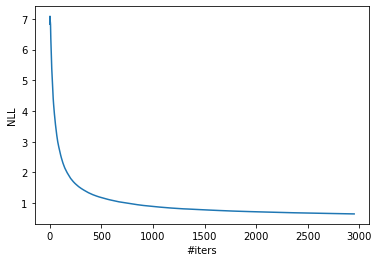

loss: 0.6465: 100%|██████████| 3000/3000 [00:25<00:00, 118.96it/s]


In [28]:
import time

from IPython import display  # type: ignore
from IPython.display import clear_output  # type: ignore
from tqdm import tqdm

pbar = tqdm(range(NUM_ITERS))
agg_loss = train.RunningMean(0., 0)
losses = []


for i in pbar:
    
    loss, params, opt_state = step(next(chain), params, opt_state)  # type: ignore
    agg_loss = agg_loss.update(loss)
    losses.append(agg_loss.value)
    
    pbar.set_description(f"loss: {agg_loss.value:.4}")
    if not i % PLOT_INTERVAL:
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.ylabel("NLL")
        plt.xlabel("#iters")
    
        plt.show()
        time.sleep(0.001)

# Check inverses

In [29]:
a = flow.with_params(params).forward(
    initializer.obj
)
b = flow.with_params(params).inverse(
    a.obj
)
b, initializer, a

(Transformed(obj=State(pos=DeviceArray([1.1530281], dtype=float32), aux=DeviceArray([-0.5456246], dtype=float32)), ldj=DeviceArray(0.3417605, dtype=float32)),
 Transformed(obj=State(pos=DeviceArray([1.1530274], dtype=float32), aux=DeviceArray([-0.54562485], dtype=float32)), ldj=DeviceArray(2.6514664, dtype=float32)),
 Transformed(obj=State(pos=DeviceArray([-0.9055319], dtype=float32), aux=DeviceArray([-1.0297807], dtype=float32)), ldj=DeviceArray(-0.34176147, dtype=float32)))

# Sample after training

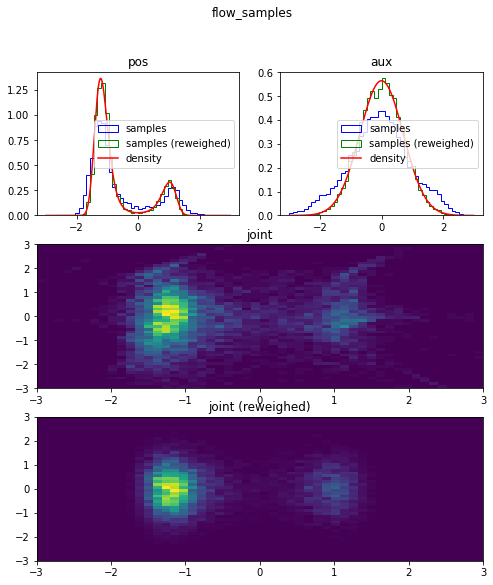

In [30]:
from flox.flow import PushforwardSampler

out = jax.jit(jax.vmap(PushforwardSampler(sample_base, flow.with_params(params))))(jax.random.split(next(chain), 10_000))

weights = jax.nn.softmax(
    -jax.vmap(joint_target_potential)(out.obj) + out.ldj
)

plot_samples(out.obj, (double_well_potential, harmonic_potential), label="flow_samples", weights=weights)